<h1><center><font size="6">Hyperparameter Tuning and Class Imbalance Notebook</font></center></h1>



# <a id='0'>Contents</a>

- <a href='#1'>Importing Packages</a>
- <a href='#2'>Preparing Data for Modeling</a>  
- <a href='#3'>Hyperparameter Tuning</a>
    - <a href='#31'>Logistic Regression with GridSearchCV</a>
    - <a href='#32'>Random Forest Classifier with GridSearchCV</a>
    - <a href='#33'>Decision Tree Classifier with GridSearchCV</a>
    - <a href='#34'>AdaBoost Classifier with GridSearchCV</a>
    - <a href='#35'>Gradient Boosting Classifier with GridSearchCV</a>
    - <a href='#36'>XGBoost Classifier with GridSearchCV</a>
    - <a href='#37'>Evaluation Metrics</a>
- <a href='#4'>Class Imbalance</a>
    - <a href='#41'>Ensemble Methods</a>
    - <a href='#42'>Under/Downsampling Methods for Majority Class</a>
    - <a href='#43'>Over/Upsampling Methods for Minority Class</a>
    - <a href='#44'>Recursive Feature Elimination with Cross-Validation</a>
- <a href='#5'>Discussion of Evaluation Metrics</a>


# <a id='1'>Importing Packages</a>

In [1]:
import numpy as np 
import pandas as pd
import re
from matplotlib import pyplot as plt
from matplotlib import style
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import itertools
from collections import Counter


from sklearn import linear_model
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score, classification_report, plot_confusion_matrix, auc, mean_squared_error, confusion_matrix, balanced_accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier, EasyEnsembleClassifier, RUSBoostClassifier
from imblearn.metrics import geometric_mean_score
from imblearn.under_sampling import TomekLinks

import xgboost as xgb
from xgboost.sklearn import XGBClassifier


%reload_ext autoreload
%autoreload 2

from utils import *

plt.style.use("fivethirtyeight")
sns.set_theme(style="darkgrid", font='serif', context='poster')

import pickle

from imblearn.under_sampling import NeighbourhoodCleaningRule
from matplotlib import pyplot
from numpy import where
from imblearn.under_sampling import NearMiss 
from imblearn.under_sampling import OneSidedSelection
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.dummy import DummyClassifier
from sklearn.utils import resample
from sklearn.model_selection import cross_validate

# <a id='2'>Preparing Data for Modeling</a>

In [7]:
pickle_in = open("../data/training_model.pickle","rb")
train = pickle.load(pickle_in)
pickle_in = open("../data/validate_model.pickle","rb")
validate = pickle.load(pickle_in)

In [8]:
train.head()

,limit,behind1,paid2,delayed,latemths,age,behind2,billed1,avg_av,avail1,default
0,1790.26,0,179.13,0,0,44,0,1631.93,0.344578,0.088440,0
1,5728.83,-1,173.87,0,0,46,-1,891.69,0.957227,0.844350,0
2,3580.52,-1,0.00,0,0,47,-1,238.68,0.968650,0.933339,1
3,6086.88,0,89.26,0,0,29,0,2831.87,0.650602,0.534758,0
4,5370.78,-2,1171.37,0,0,33,-2,873.40,0.836153,0.837379,0


In [11]:
X_train = train.drop(["default"], axis=1)
y_tr = train["default"]
X_validate = validate.drop(["default"], axis=1)
y_val = validate["default"]

In [12]:
scaler = StandardScaler()
scaler.fit(X_train)
X_tr = scaler.transform(X_train)
X_val = scaler.transform(X_validate)

# <a id='3'>Hyperparameter Tuning</a>

## <a id='31'>Logistic Regression with GridSearchCV</a>

Best: 0.522622 using {'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}

Training Accuracy:  0.8087142857142857
Validation Accuracy:  0.8071666666666667
Training F1 Score:  0.40320903283316006
Validation F1 Score:  0.380952380952381
Training AUC Score:  0.7476971040793051
Validation AUC Score:  0.7467126831177808
Training Recall Score:  0.2914518900343643
Validation Recall Score:  0.27113480578827115
Training Precision Score:  0.6539759036144578
Validation Precision Score:  0.6402877697841727
Training Average Precision Score:  0.5205202430336466
Validation Average Precision Score:  0.4986582661881126

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.96      0.89     16344
           1       0.65      0.29      0.40      4656

    accuracy                           0.81     21000
   macro avg       0.74      0.62      0.64     21000
weighted avg       0.79      0.81      0.78     21000


Validation Classification Report

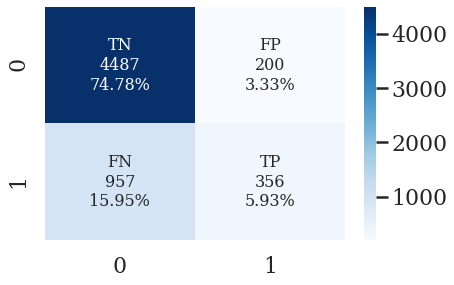

In [14]:
logreg = LogisticRegression()
params = {'C': [0.001, 0.01, 0.1, 1, 10], 
          'penalty': ['none', 'l1', 'l2', 'elasticnet'],
          'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']}
gslog = GridSearchCV(estimator = logreg,
                     param_grid = params,
                     scoring = 'average_precision',
                     cv = 10,
                     n_jobs = -1).fit(X_tr, y_tr)
y_pred_gslog_tr = gslog.predict(X_tr)
y_pred_gslog_val = gslog.predict(X_val)
print("Best: %f using %s" % (gslog.best_score_, gslog.best_params_))
print("")
get_metrics(X_tr, y_tr, X_val, y_val, y_pred_gslog_tr, y_pred_gslog_val, gslog)

# Best: 0.522622 using {'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}

In [15]:
# logb = LogisticRegression(C=1, penalty='l1', solver='saga').fit(X_tr, y_tr)
# y_pred_logb_tr = logb.predict(X_tr)
# y_pred_logb_val = logb.predict(X_val)
# get_metrics(X_tr, y_tr, X_val, y_val, y_pred_logb_tr, y_pred_logb_val, logb)

## <a id='33'>Random Forest Classifier with GridSearchCV</a>

In [8]:
rfc = RandomForestClassifier()
params = {'n_estimators': [100, 200, 400, 600, 1000],
          'criterion': ['entropy', 'gini'],
          'max_depth': [5, 8, 15, 25, 30],
          'min_samples_split': [2, 5, 10, 15, 100],
          'min_samples_leaf': [1, 2, 5, 10]}
gsrfc = GridSearchCV(estimator = rfc,
                     param_grid = params,
                     scoring = 'average_precision',
                     cv = 5,
                     n_jobs = -1).fit(X_tr, y_tr)
y_pred_gsrfc_tr = gsrfc.predict(X_tr)
y_pred_gsrfc_val = gsrfc.predict(X_val)
print("Best: %f using %s" % (gsrfc.best_score_, gsrfc.best_params_))
print("")
get_metrics(X_tr, y_tr, X_val, y_val, y_pred_gsrfc_tr, y_pred_gsrfc_val, gsrfc)

# 

Training Accuracy:  0.8371428571428572
Validation Accuracy:  0.8231666666666667
Training F1 Score:  0.5259218186858886
Validation F1 Score:  0.4739712444224095
Training AUC Score:  0.8392557556037463
Validation AUC Score:  0.7801020176856437
Training Recall Score:  0.4074312714776632
Validation Recall Score:  0.36405178979436403
Training Precision Score:  0.7415949960906959
Validation Precision Score:  0.6789772727272727
Training Average Precision Score:  0.6640997787592029
Validation Average Precision Score:  0.5420886372755647

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.96      0.90     16344
           1       0.74      0.41      0.53      4656

    accuracy                           0.84     21000
   macro avg       0.80      0.68      0.71     21000
weighted avg       0.83      0.84      0.82     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0 

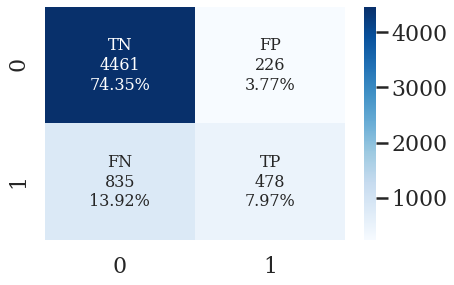

In [9]:
# rfcb = RandomForestClassifier(criterion='entropy', max_depth=8, min_samples_leaf=2, min_samples_split=5, n_estimators=1000).fit(X_tr, y_tr)
# y_pred_rfcb_tr = rfcb.predict(X_tr)
# y_pred_rfcb_val = rfcb.predict(X_val)
# get_metrics(X_tr, y_tr, X_val, y_val, y_pred_rfcb_tr, y_pred_rfcb_val, rfcb)

## <a id='34'>AdaBoost Classifier with GridSearchCV</a>

In [10]:
abc = AdaBoostClassifier()
params = {'n_estimators': [10, 50, 100, 200],
          'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.5]}
gsabc = GridSearchCV(estimator = abc,
                     param_grid = params,
                     n_jobs = -1,
                     cv = 5,
                     scoring = 'average_precision').fit(X_tr, y_tr)
y_pred_gsabc_tr = gsabc.predict(X_tr)
y_pred_gsabc_val = gsabc.predict(X_val)
print("Best: %f using %s" % (gsabc.best_score_, gsabc.best_params_))
print("")
get_metrics(X_tr, y_tr, X_val, y_val, y_pred_gsabc_tr, y_pred_gsabc_val, gsabc)

# 

Training Accuracy:  0.8212380952380952
Validation Accuracy:  0.8196666666666667
Training F1 Score:  0.4614060258249641
Validation F1 Score:  0.44398766700924974
Training AUC Score:  0.7959504841042163
Validation AUC Score:  0.7801845652061226
Training Recall Score:  0.34536082474226804
Validation Recall Score:  0.32901751713632904
Training Precision Score:  0.6949006050129646
Validation Precision Score:  0.6824644549763034
Training Average Precision Score:  0.5660140542890106
Validation Average Precision Score:  0.5323410573049978

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.96      0.89     16344
           1       0.69      0.35      0.46      4656

    accuracy                           0.82     21000
   macro avg       0.77      0.65      0.68     21000
weighted avg       0.81      0.82      0.80     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           

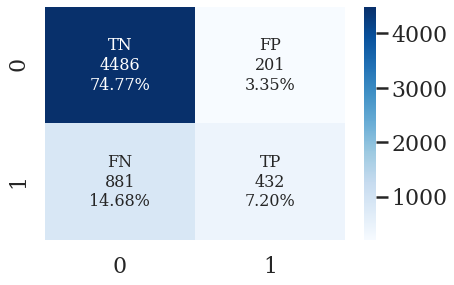

In [11]:
# abcb = AdaBoostClassifier(learning_rate=0.2, n_estimators=200).fit(X_tr, y_tr)
# y_pred_abcb_tr = abcb.predict(X_tr)
# y_pred_abcb_val = abcb.predict(X_val)
# get_metrics(X_tr, y_tr, X_val, y_val, y_pred_abcb_tr, y_pred_abcb_val, abcb)

## <a id='35'>Gradient Boosting with GridSearchCV</a>

In [12]:
gbc = GradientBoostingClassifier()
params = {'n_estimators': [10, 100, 1000],
          'learning_rate': [0.001, 0.01, 0.1],
          'max_depth': [3, 7, 9]}
gsgbc = GridSearchCV(estimator = gbc,
                     param_grid = params, 
                     n_jobs = -1, 
                     cv = 5, 
                     scoring = 'average_precision').fit(X_tr, y_tr)
y_pred_gsgbc_tr = gsgbc.predict(X_tr)
y_pred_gsgbc_val = gsgbc.predict(X_val)
print("Best: %f using %s" % (gsgbc.best_score_, gsgbc.best_params_))
print("")
get_metrics(X_tr, y_tr, X_val, y_val, y_pred_gsgbc_tr, y_pred_gsgbc_tr, gsgbc)

# 

Training Accuracy:  0.8288095238095238
Validation Accuracy:  0.821
Training F1 Score:  0.499930449297538
Validation F1 Score:  0.4656716417910448
Training AUC Score:  0.8138657843688867
Validation AUC Score:  0.7830492729074651
Training Recall Score:  0.3859536082474227
Validation Recall Score:  0.3564356435643564
Training Precision Score:  0.7094354520331623
Validation Precision Score:  0.6714490674318508
Training Average Precision Score:  0.6119302284370578
Validation Average Precision Score:  0.5439279188037631

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.95      0.90     16344
           1       0.71      0.39      0.50      4656

    accuracy                           0.83     21000
   macro avg       0.78      0.67      0.70     21000
weighted avg       0.82      0.83      0.81     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0       0.84     

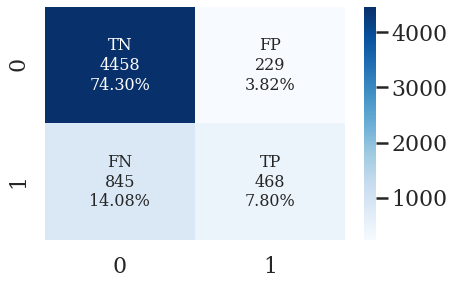

In [13]:
# gbcb = GradientBoostingClassifier(learning_rate=0.01, max_depth=3, n_estimators=1000).fit(X_tr, y_tr)
# y_pred_gbcb_tr = gbcb.predict(X_tr)
# y_pred_gbcb_val = gbcb.predict(X_val)
# get_metrics(X_tr, y_tr, X_val, y_val, y_pred_gbcb_tr, y_pred_gbcb_val, gbcb)

## <a id='36'>XGBoost Classifier with GridSearchCV</a>

In [14]:
xgb = XGBClassifier()
params = {'n_estimators': [50, 100, 150, 200], 
          'max_depth': [3, 5, 7, 10], 
          'min_child_weight': [2, 3, 4, 5]}
gsxgb = GridSearchCV(estimator = xgb,
                     param_grid = params,
                     scoring = 'average_precision',
                     cv = 5,
                     n_jobs = -1).fit(X_tr, y_tr)
y_pred_gsxgb_tr = gsxgb.predict(X_tr)
y_pred_gsxgb_val = gsxgb.predict(X_val)
print("Best: %f using %s" % (gsxgb.best_score_, gsxgb.best_params_))
print("")
get_metrics(X_tr, y_tr, X_val, y_val, y_pred_gsxgb_tr, y_pred_gsxgb_val, gsxgb)

# 


[00:42:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Accuracy:  0.8281904761904761
Validation Accuracy:  0.82
Training F1 Score:  0.4995839112343967
Validation F1 Score:  0.4653465346534654
Training AUC Score:  0.8202041458197717
Validation AUC Score:  0.7791023477132305
Training Recall Score:  0.3868127147766323
Validation Recall Score:  0.357958872810358
Training Precision Score:  0.7051683633516054
Validation Precision Score:  0.6647807637906648
Training Average Precision Score:  0.6169489485421569
Validation Average Precision Score:  0.5386331254323531

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.95      0.90     16344
           1       0.71    

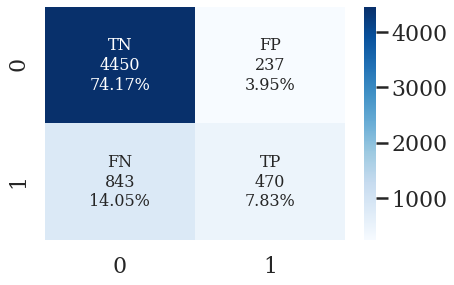

In [15]:
# xgbb = XGBClassifier(max_depth=3, min_child_weight=3, n_estimators=50).fit(X_tr, y_tr)
# y_pred_xgbb_tr = xgbb.predict(X_tr)
# y_pred_xgbb_val = xgbb.predict(X_val)
# get_metrics(X_tr, y_tr, X_val, y_val, y_pred_xgbb_tr, y_pred_xgbb_val, xgbb)

## <a id='37'>Evaluation Metrics</a>

In [16]:
data = {'Accuracy': [accuracy(y_val, y_pred_logb_val), 
                     accuracy(y_val, y_pred_rfcb_val), 
                     accuracy(y_val, y_pred_abcb_val), 
                     accuracy(y_val, y_pred_gbcb_val),
                     accuracy(y_val, y_pred_xgbb_val)],
        'F1 Score': [f1(y_val, y_pred_logb_val), 
                     f1(y_val, y_pred_rfcb_val), 
                     f1(y_val, y_pred_abcb_val), 
                     f1(y_val, y_pred_gbcb_val),
                     f1(y_val, y_pred_xgbb_val)],
        'Recall': [recall(y_val, y_pred_logb_val), 
                   recall(y_val, y_pred_rfcb_val), 
                   recall(y_val, y_pred_abcb_val),
                   recall(y_val, y_pred_gbcb_val),
                   recall(y_val, y_pred_xgbb_val)],
        'Precision': [precision(y_val, y_pred_logb_val), 
                      precision(y_val, y_pred_rfcb_val), 
                      precision(y_val, y_pred_abcb_val),
                      precision(y_val, y_pred_gbcb_val),
                      precision(y_val, y_pred_xgbb_val)],
        'PR AUC': [aps(X_val, y_val, logb),
                   aps(X_val, y_val, rfcb),
                   aps(X_val, y_val, abcb),
                   aps(X_val, y_val, gbcb),
                   aps(X_val, y_val, xgbb)]}
scores3 = pd.DataFrame(data=data, index = ['Logistic Regression with GridSearchCV', 
                                          'Random Forest with GridSearchCV', 
                                          'AdaBoost with GridSearchCV', 
                                          'Gradient Boosting with GridSearchCV',
                                          'XGBoost with GridSearchCV'])

In [17]:
scores3

,Accuracy,F1 Score,Recall,Precision,PR AUC
Logistic Regression with GridSearchCV,0.808000,0.395593,0.287129,0.635750,0.499776
Random Forest with GridSearchCV,0.823167,0.473971,0.364052,0.678977,0.542089
AdaBoost with GridSearchCV,0.819667,0.443988,0.329018,0.682464,0.532341
Gradient Boosting with GridSearchCV,0.821000,0.465672,0.356436,0.671449,0.543928
XGBoost with GridSearchCV,0.820000,0.465347,0.357959,0.664781,0.538633


## Pickle out best model

In [18]:
rfcb

RandomForestClassifier(criterion='entropy', max_depth=8, min_samples_leaf=2,
                       min_samples_split=5, n_estimators=1000)

In [19]:
pickle_out = open("../data/best_model.pickle","wb")
pickle.dump(rfcb, pickle_out)
pickle_out.close()

# <a id='4'>Class Imbalance</a>

## <a id='41'>Ensemble Methods</a>

Training Accuracy:  0.9987142857142857
Validation Accuracy:  0.8113333333333334
Training F1 Score:  0.9970933362041124
Validation F1 Score:  0.4412635735439289
Training AUC Score:  0.9999941062579792
Validation AUC Score:  0.7434372690030324
Training Recall Score:  0.9946305841924399
Validation Recall Score:  0.34044173648134046
Training Precision Score:  0.9995683142672135
Validation Precision Score:  0.6269284712482468
Training Average Precision Score:  0.9999787231951094
Validation Average Precision Score:  0.4960314980682107

Training Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16344
           1       1.00      0.99      1.00      4656

    accuracy                           1.00     21000
   macro avg       1.00      1.00      1.00     21000
weighted avg       1.00      1.00      1.00     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0 

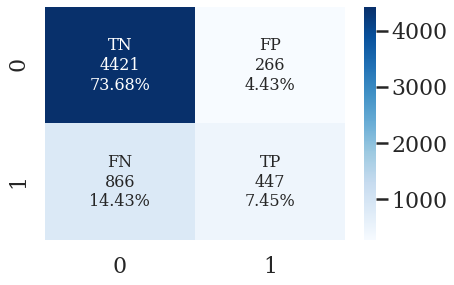

In [21]:
bc = BaggingClassifier(n_estimators=50, random_state=42).fit(X_tr, y_tr)
y_pred_bc_tr = bc.predict(X_tr)
y_pred_bc_val = bc.predict(X_val)
get_metrics(X_tr, y_tr, X_val, y_val, y_pred_bc_tr, y_pred_bc_val, bc)
print("")
print('Bagging Classifier Performance:')
print('Balanced training accuracy: {:.2f} - Geometric mean {:.2f}'.format(balanced_accuracy_score(y_tr, y_pred_bc_tr), geometric_mean_score(y_tr, y_pred_bc_tr)))
print('Balanced validation accuracy: {:.2f} - Geometric mean {:.2f}'.format(balanced_accuracy_score(y_val, y_pred_bc_val), geometric_mean_score(y_val, y_pred_bc_val)))

Training Accuracy:  0.946
Validation Accuracy:  0.7815
Training F1 Score:  0.8913793103448276
Validation F1 Score:  0.5227520931925738
Training AUC Score:  0.9969609513900453
Validation AUC Score:  0.7641678275588795
Training Recall Score:  0.9993556701030928
Validation Recall Score:  0.5468392993145469
Training Precision Score:  0.8044605809128631
Validation Precision Score:  0.500697350069735
Training Average Precision Score:  0.9874460704342363
Validation Average Precision Score:  0.5144220523174241

Training Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     16344
           1       0.80      1.00      0.89      4656

    accuracy                           0.95     21000
   macro avg       0.90      0.97      0.93     21000
weighted avg       0.96      0.95      0.95     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0       0.87      0.85      0

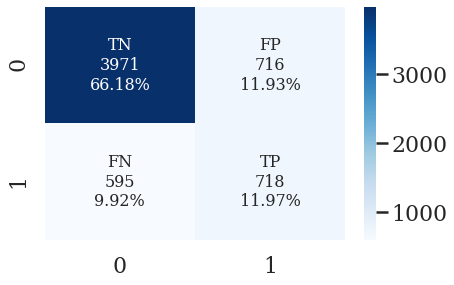

In [22]:
bbc = BalancedBaggingClassifier(n_estimators=50, random_state=42).fit(X_tr, y_tr)
y_pred_bbc_tr = bbc.predict(X_tr)
y_pred_bbc_val = bbc.predict(X_val)
get_metrics(X_tr, y_tr, X_val, y_val, y_pred_bbc_tr, y_pred_bbc_val, bbc)
print("")
print('Balanced Bagging Classifier Performance:')
print('Balanced training accuracy: {:.2f} - Geometric mean {:.2f}'.format(balanced_accuracy_score(y_tr, y_pred_bbc_tr), geometric_mean_score(y_val, y_pred_bbc_tr)))
print('Balanced validation accuracy: {:.2f} - Geometric mean {:.2f}'.format(balanced_accuracy_score(y_val, y_pred_bbc_val), geometric_mean_score(y_val, y_pred_bbc_val)))

## <a id='42'>Undersampling/Downsampling Methods for Majority Class</a>

In [15]:
# separate minority and majority classes
majority = train[train.default==0]
minority = train[train.default==1]

#baseline counts
counter = Counter(y_tr)
print("Baseline: ", counter)

Baseline:  Counter({0: 16344, 1: 4656})


In [18]:
downsampled = resample(majority, replace = False, n_samples = len(minority), random_state=42)
dns = pd.concat([downsampled, minority])
print(dns.default.value_counts())

1    4656
0    4656
Name: default, dtype: int64

In [22]:
ns = NearMiss(version=1, n_neighbors=3)
X_tr_nm, y_tr_nm = ns.fit_resample(X_tr, y_tr)
counter_nm = Counter(y_tr_nm)
print("Near Miss: ", counter_nm)

Near Miss:  Counter({0: 4656, 1: 4656})


In [23]:
ncr = NeighbourhoodCleaningRule(n_neighbors=3, threshold_cleaning=0.5)
X_tr_ncr, y_tr_ncr = ncr.fit_resample(X_tr, y_tr)
counter_ncr = Counter(y_tr_ncr)
print("Neighborhood Cleaning Rule: ", counter_ncr)


Neighborhood Cleaning Rule:  Counter({0: 10212, 1: 4656})


In [24]:
oss = OneSidedSelection(n_neighbors=1, n_seeds_S=200)
X_tr_oss, y_tr_oss = oss.fit_resample(X_tr, y_tr)
counter_oss = Counter(y_tr_oss)
print("One Sided Selection: ", counter_oss)

One Sided Selection:  Counter({0: 13737, 1: 4656})


In [25]:
tl = TomekLinks()
X_tr_tk, y_tr_tk = tl.fit_resample(X_tr, y_tr)
counter_tomek = Counter(y_tr_tomek)
print("Tomek Links: ", counter_tomek)

Tomek Links:  Counter({0: 15130, 1: 4656})


In [ ]:
y_pred_tk_tr

In [ ]:
abc3 = AdaBoostClassifier().fit(X_tr_tk, y_tr_tk)
y_pred_tk_tr = abc3.predict(X_tr_tk)

In [ ]:
ac = accuracy_score(y_tr_tk, y_pred_tr)
f1_score(y_tr_tk, y_pred_tk_tr)
    f1_val = f1_score(y_val, y_pred_tk_tr)
    au_tr = auc(X_tr, y_tr_tk, model)
    au_val = auc(X_val, y_val, model)
    rc_tr = recall_score(y_tr_tk, y_pred_tr)
    rc_val = recall_score(y_val, y_pred_val)
    pr_tr = precision_score(y_tr_tk, y_pred_tr)
    pr_val = precision_score(y_val, y_pred_val)
    aps_tr = aps(X_tr, y_tr_tk, model)
    aps_val = aps(X_val, y_val, model)

## <a id='43'>Oversampling/Upsampling Methods for Minority Class</a>

In [1]:
# Random Upsampling
upsampled = resample(minority, replace=True, n_samples=len(majority), random_state=42) 
ups = pd.concat([majority, upsampled])
y = ups['default']
counter_upsample = Counter(y)

NameError: name 'resample' is not defined

Training Accuracy:  0.7782857142857142
Validation Accuracy:  0.7811666666666667
Training F1 Score:  0.0
Validation F1 Score:  0.0
Training AUC Score:  0.5
Validation AUC Score:  0.5
Training Recall Score:  0.0
Validation Recall Score:  0.0
Training Precision Score:  0.0
Validation Precision Score:  0.0
Training Average Precision Score:  0.22171428571428572
Validation Average Precision Score:  0.21883333333333332

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.78      1.00      0.88     16344
           1       0.00      0.00      0.00      4656

    accuracy                           0.78     21000
   macro avg       0.39      0.50      0.44     21000
weighted avg       0.61      0.78      0.68     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0       0.78      1.00      0.88      4687
           1       0.00      0.00      0.00      1313

    accuracy           

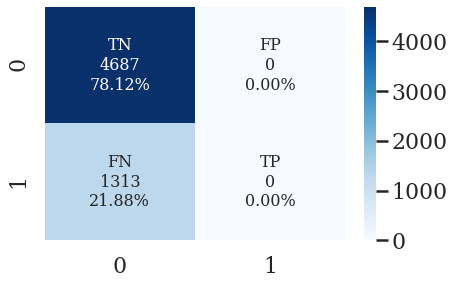

In [87]:
dc = DummyClassifier(strategy='most_frequent').fit(X_tr, y_tr)
y_pred_dc_tr = dc.predict(X_tr)
y_pred_dc_val = dc.predict(X_val)
get_metrics(X_tr, y_tr, X_val, y_val, y_pred_dc_tr, y_pred_dc_val, dc)

In [14]:
sm = SMOTE(sampling_strategy='minority', random_state=42)
X_tr_smote, y_tr_smote = sm.fit_sample(X_tr, y_tr)
counter(y_tr_smote)

NameError: name 'counter' is not defined

## Upsampling and Downsampling

In [ ]:
# define model
dtc = DecisionTreeClassifier()
# define pipeline
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under), ('m', dtc)]

# Holdout Set